## Including Libraries

In [1]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD



import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import tensorflow as tf 
print ("Done")

Done


## Including the Datasets

In [2]:
#Those are the data sets, we will be using to train the model
ravdess = "DATA/DATA/ravdess/"
Crema = "DATA/DATA/AudioWAV/"
Tess = "DATA/DATA/TESS Toronto emotional speech set data/"
Savee = "DATA/DATA/ALL/"
ravdess_directory_list = os.listdir(ravdess)

## Preprocessing


#### Ravdees dataset

In [3]:
file_emotion = []
file_path = []
for i in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(ravdess + i)
    for f in actor:
        part = f.split('.')[0].split('-')
    # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + i + '/' + f)

In [4]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)

print(ravdess_df.Emotions.value_counts())

neutral     287
surprise    192
disgust     192
fear        192
happy       192
angry       192
sad         192
Name: Emotions, dtype: int64


#### Crema dataset

In [5]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

In [6]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.Emotions.value_counts())

sad        1271
fear       1271
happy      1271
disgust    1271
angry      1271
neutral    1087
Name: Emotions, dtype: int64


#### TESS dataset

In [7]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        if "." in file:
            part = file.split('.')[0]
            part = part.split('_')[2]
            if part=='ps':
                file_emotion.append('surprise')
            else:
                file_emotion.append(part)
            file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df.Emotions.value_counts())

surprise    400
disgust     400
angry       400
sad         400
neutral     400
fear        400
happy       400
Name: Emotions, dtype: int64


#### SAVEE Dataset

In [8]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
print(Savee_df.Emotions.value_counts())

neutral     120
happy        60
disgust      60
fear         60
surprise     60
sad          60
angry        60
Name: Emotions, dtype: int64


#### Integrate datasets

In [9]:
# creating Dataframe using all the 3 dataframes we created so far.
data_path = pd.concat([ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head(1)

,Emotions,Path
0,angry,DATA/DATA/ravdess/Actor_02/03-01-05-01-01-02-0...


In [10]:
print(data_path.Emotions.value_counts())

sad         1923
happy       1923
fear        1923
disgust     1923
angry       1923
neutral     1894
surprise     652
Name: Emotions, dtype: int64


## Data augmentation

###### Data augmentation is a technique of artificially increasing the training set by creating modified copies of a dataset using existing data. This is used to create elements with new variations in order to predict every audio. 

In [11]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

## Feature extraction

In [12]:
#The rate of sign-changes of the signal during the frame
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
#The electrical power your audio signal creates over time
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
#Set of coefficients that capture the shape of the power spectrum of a sound signa
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)
    
    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))
    
    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))
    
    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))
    
    stretch_audio=stretch(data,sr)
    aud5=extract_features(stretch_audio)
    audio=np.vstack((audio,aud5))
    
    return audio

In [13]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  16


###### We will use the joblib library to process multiple audio files in parallel using the process_feature function. The perfonmance of this library depends on the number of processors, in this example 16 are used. 

In [14]:
from joblib import Parallel, delayed
import timeit
from tqdm import tqdm
start = timeit.default_timer()
def process_feature(path, emotion):
    features = get_features(path)
    X = []
    Y = []
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
    return X, Y

paths = data_path.Path
emotions = data_path.Emotions

# Run the loop in parallel
results = Parallel(n_jobs=-1)(delayed(process_feature)(path, emotion) for (path, emotion) in zip(paths, emotions))

# Collect the results
X = []
Y = []
for result in results:
    x, y = result
    X.extend(x)
    Y.extend(y)


stop = timeit.default_timer()

print('Time: ', stop - start)

Time:  4347.641478800913


###### It took 4347.64 seconds to proccess all the data, whereas, not using the joblib library it would have taken almost an hour on this server.

## Saving features

In [15]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.head(100)

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.173340,0.324707,0.483398,0.507324,0.439941,0.346680,0.250488,0.230957,0.248535,0.245605,...,4.207337,3.875172,3.538487,3.201609,2.868634,2.543363,2.229210,1.929212,1.645933,angry
1,0.249023,0.373047,0.493652,0.498047,0.492188,0.500000,0.479492,0.465820,0.441406,0.394531,...,3.472936,2.730981,-0.498687,-3.251477,-3.788345,-2.782140,-0.832183,-6.640763,-0.530114,angry
2,0.093750,0.137695,0.179199,0.190918,0.199219,0.214844,0.231445,0.234375,0.234863,0.232422,...,2.755695,2.611968,2.465471,2.317832,2.170549,2.024962,1.882213,1.743268,1.608866,angry
3,0.247070,0.368164,0.492676,0.490723,0.485840,0.473145,0.453125,0.416016,0.388184,0.365234,...,-2.687025,-3.854253,0.648255,1.220369,2.550457,3.115511,-0.978896,2.143652,3.490360,angry
4,0.156738,0.217285,0.276855,0.244629,0.235352,0.236816,0.231445,0.226074,0.227051,0.236816,...,0.831039,0.758321,0.684298,0.609933,0.536178,0.463953,0.394069,0.327364,0.264539,surprise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.261230,0.392090,0.520508,0.513672,0.515137,0.515625,0.506836,0.515625,0.508301,0.493652,...,2.432724,0.585190,1.926563,4.290768,2.594734,-0.578072,-6.517926,-0.091841,2.304176,happy
96,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.792031,1.239079,2.757663,1.805864,-0.227590,-1.503050,-1.284721,-0.240708,0.446153,disgust
97,0.257812,0.375977,0.497559,0.494629,0.486816,0.481445,0.485840,0.479980,0.477051,0.494141,...,-4.259009,-6.065946,-8.012761,-4.009353,-0.164604,-0.195352,-1.820729,-4.512944,-4.894891,disgust
98,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.392149,-0.179585,0.679380,0.530583,-0.411219,-1.347612,-1.605447,-1.167214,-0.619856,disgust


In [16]:
Emotions.to_csv('emotion.csv', index=False)

In [17]:
Emotions.shape

(48644, 2377)

## Data preparation

In [18]:
#check if there is any invalid data
print(Emotions.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [19]:
#fill the invalid data with 0
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(48644, 2377)

In [20]:
#taking all rows and all cols without last col for X which include features
#taking last col for Y, which include the emotions
X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [21]:
X

array([[ 0.17333984,  0.32470703,  0.48339844, ...,  2.2292099 ,
         1.92921209,  1.64593267],
       [ 0.24902344,  0.37304688,  0.49365234, ..., -0.83218319,
        -6.64076308, -0.530114  ],
       [ 0.09375   ,  0.13769531,  0.17919922, ...,  1.88221335,
         1.74326754,  1.60886598],
       ...,
       [ 0.02197266,  0.03027344,  0.04150391, ...,  1.89541394,
         3.4948538 ,  7.15315669],
       [ 0.02197266,  0.03515625,  0.04443359, ...,  0.34384984,
         1.77898192,  3.38057899],
       [ 0.02294922,  0.04296875,  0.05419922, ...,  4.25113559,
         2.26402261,  0.09115696]])

In [22]:
Y

array(['angry', 'angry', 'angry', ..., 'angry', 'angry', 'angry'],
      dtype=object)

In [23]:
#As we can see, Y is a list of the emotions, we would need to encode all these values. 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [24]:
Y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [25]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38915, 2376), (38915, 7), (9729, 2376), (9729, 7))

In [26]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38915, 2376), (38915, 7), (9729, 2376), (9729, 7))

## Trainig a CNN model

In [27]:
#Reshape for CNN_LSTM MODEL
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((38915, 2376, 1), (38915, 7), (9729, 2376, 1), (9729, 7))

In [28]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
early_stop=EarlyStopping(monitor='val_acc',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

In [29]:
import tensorflow.keras.layers as L

model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(x_traincnn.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer
    
    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer
    
    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer
    
    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(7,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2376, 512)         3072      
_________________________________________________________________
batch_normalization (BatchNo (None, 2376, 512)         2048      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1188, 512)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1188, 512)         1311232   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1188, 512)         2048      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 594, 512)          0         
_________________________________________________________________
dropout (Dropout)            (None, 594, 512)          0

In [30]:
history=model.fit(x_traincnn, y_train, epochs=50, validation_data=(x_testcnn, y_test), batch_size=64,callbacks=[early_stop,lr_reduction])

Epoch 1/50
609/609 [==============================] - 166s 272ms/step - loss: 1.4001 - accuracy: 0.4704 - val_loss: 1.2604 - val_accuracy: 0.5015
Epoch 2/50
609/609 [==============================] - 164s 270ms/step - loss: 1.1019 - accuracy: 0.5743 - val_loss: 1.2359 - val_accuracy: 0.5307
Epoch 3/50
609/609 [==============================] - 164s 269ms/step - loss: 1.0523 - accuracy: 0.5946 - val_loss: 0.9843 - val_accuracy: 0.6171
Epoch 4/50
609/609 [==============================] - 164s 269ms/step - loss: 0.9002 - accuracy: 0.6572 - val_loss: 0.8923 - val_accuracy: 0.6538
Epoch 5/50
609/609 [==============================] - 164s 269ms/step - loss: 0.7919 - accuracy: 0.7007 - val_loss: 1.0919 - val_accuracy: 0.5875
Epoch 6/50
609/609 [==============================] - 164s 270ms/step - loss: 0.7598 - accuracy: 0.7130 - val_loss: 1.0676 - val_accuracy: 0.6113
Epoch 7/50
609/609 [==============================] - 164s 269ms/step - loss: 0.6529 - accuracy: 0.7556 - val_loss: 0.6795 -

Epoch 16/50
609/609 [==============================] - 164s 269ms/step - loss: 0.0805 - accuracy: 0.9744 - val_loss: 0.1859 - val_accuracy: 0.9401
Epoch 17/50
609/609 [==============================] - 164s 269ms/step - loss: 0.0919 - accuracy: 0.9699 - val_loss: 0.1845 - val_accuracy: 0.9377
Epoch 18/50
609/609 [==============================] - 164s 270ms/step - loss: 0.1175 - accuracy: 0.9599 - val_loss: 0.2811 - val_accuracy: 0.9074
Epoch 19/50
609/609 [==============================] - 148s 242ms/step - loss: 0.0569 - accuracy: 0.9818 - val_loss: 0.1722 - val_accuracy: 0.9471
Epoch 20/50
609/609 [==============================] - 164s 270ms/step - loss: 0.0775 - accuracy: 0.9741 - val_loss: 0.2143 - val_accuracy: 0.9314
Epoch 21/50
609/609 [==============================] - 164s 269ms/step - loss: 0.0860 - accuracy: 0.9703 - val_loss: 0.1554 - val_accuracy: 0.9488
Epoch 22/50
609/609 [==============================] - 164s 269ms/step - loss: 0.0399 - accuracy: 0.9873 - val_loss: 0

609/609 [==============================] - 164s 269ms/step - loss: 0.0468 - accuracy: 0.9842 - val_loss: 0.1511 - val_accuracy: 0.9551
Epoch 32/50
609/609 [==============================] - 164s 270ms/step - loss: 0.0614 - accuracy: 0.9794 - val_loss: 0.1494 - val_accuracy: 0.9544
Epoch 33/50
609/609 [==============================] - 164s 270ms/step - loss: 0.0370 - accuracy: 0.9881 - val_loss: 0.1233 - val_accuracy: 0.9627
Epoch 34/50
609/609 [==============================] - 164s 270ms/step - loss: 0.0241 - accuracy: 0.9922 - val_loss: 0.1165 - val_accuracy: 0.9656
Epoch 35/50
609/609 [==============================] - 164s 269ms/step - loss: 0.0360 - accuracy: 0.9880 - val_loss: 0.1232 - val_accuracy: 0.9642
Epoch 36/50
609/609 [==============================] - 164s 269ms/step - loss: 0.0345 - accuracy: 0.9890 - val_loss: 0.1223 - val_accuracy: 0.9660
Epoch 37/50
609/609 [==============================] - 164s 269ms/step - loss: 0.0283 - accuracy: 0.9906 - val_loss: 0.1489 - val_

609/609 [==============================] - 165s 270ms/step - loss: 0.0341 - accuracy: 0.9893 - val_loss: 0.1530 - val_accuracy: 0.9609
Epoch 47/50
609/609 [==============================] - 165s 270ms/step - loss: 0.0464 - accuracy: 0.9858 - val_loss: 0.1194 - val_accuracy: 0.9689
Epoch 48/50
609/609 [==============================] - 164s 269ms/step - loss: 0.0428 - accuracy: 0.9865 - val_loss: 0.1267 - val_accuracy: 0.9666
Epoch 49/50
609/609 [==============================] - 146s 239ms/step - loss: 0.0176 - accuracy: 0.9944 - val_loss: 0.1062 - val_accuracy: 0.9717
Epoch 50/50
609/609 [==============================] - 165s 270ms/step - loss: 0.0167 - accuracy: 0.9943 - val_loss: 0.1311 - val_accuracy: 0.9667


305/305 [==============================] - 13s 41ms/step - loss: 0.1311 - accuracy: 0.9667
Accuracy of our model on test data :  96.66975140571594 %


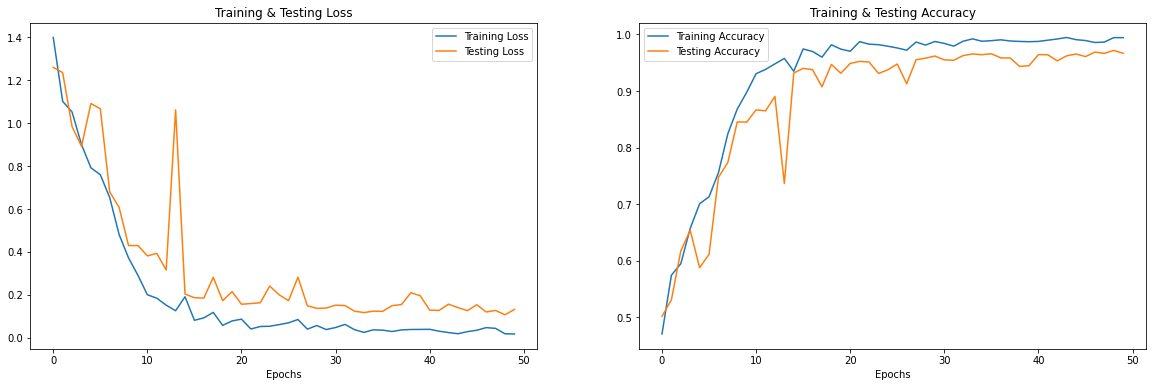

In [31]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [32]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0

,Predicted Labels,Actual Labels
0,happy,happy
1,fear,fear
2,disgust,disgust
3,disgust,disgust
4,neutral,neutral
...,...,...
9724,disgust,disgust
9725,surprise,surprise
9726,happy,happy
9727,surprise,surprise


## Evalutation

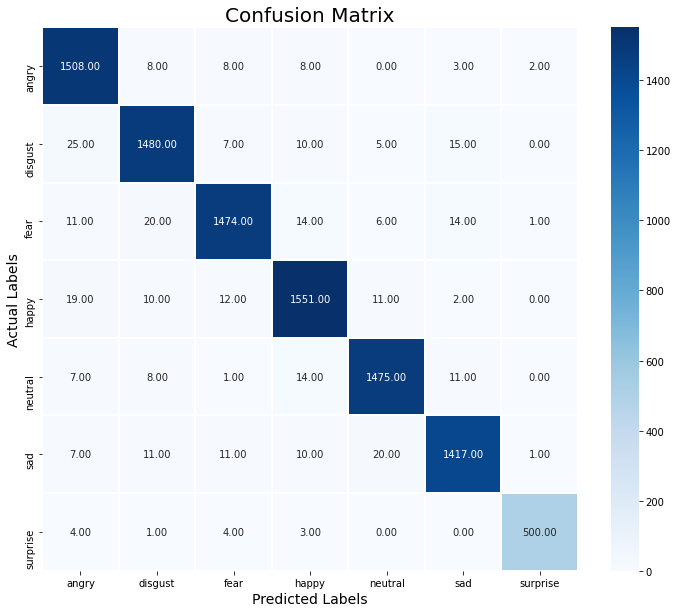

              precision    recall  f1-score   support

       angry       0.95      0.98      0.97      1537
     disgust       0.96      0.96      0.96      1542
        fear       0.97      0.96      0.96      1540
       happy       0.96      0.97      0.96      1605
     neutral       0.97      0.97      0.97      1516
         sad       0.97      0.96      0.96      1477
    surprise       0.99      0.98      0.98       512

    accuracy                           0.97      9729
   macro avg       0.97      0.97      0.97      9729
weighted avg       0.97      0.97      0.97      9729



In [33]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))

## Saving Model

In [34]:
from tensorflow.keras.models import Sequential, model_from_json
model_json = model.to_json()
with open("CNN_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("CNN_model_weights.h5")
print("Saved model to disk") 

Saved model to disk


In [35]:
import pickle

# Saving scaler
with open('scaler2.pickle', 'wb') as f:
    pickle.dump(scaler, f)

# Loading scaler
with open('scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

# Saving encoder
with open('encoder2.pickle', 'wb') as f:
    pickle.dump(encoder, f)

# Loading encoder
with open('encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)

    
print("Done")    

Done
